# Visualize the 2-link IK data

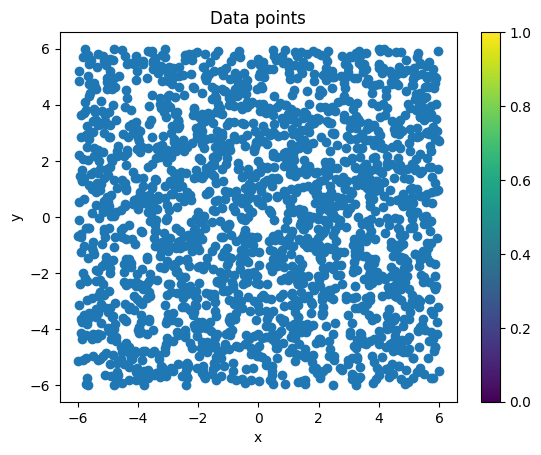

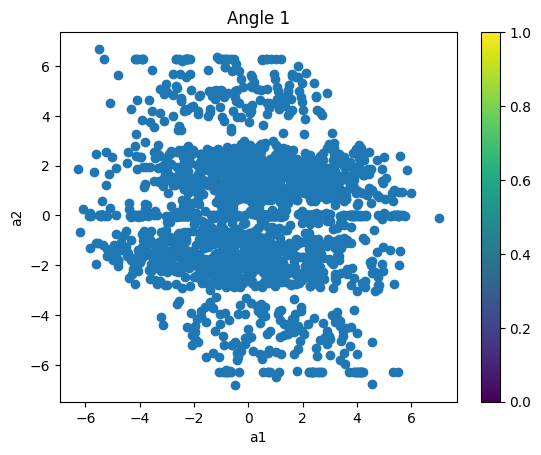

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('./data/gradient_data_rs.npy')

# the first two columns are the x and y coordinates of the data points
# the third and fourth columns are the angle 1 and angle 2

# plot the data points
# as expected, the data points are randomly distributed
plt.figure()
plt.scatter(data[:,0], data[:,1])
plt.colorbar()
plt.title('Data points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# plot the angles
plt.figure()
plt.scatter(data[:,2], data[:,3])
plt.colorbar()
plt.title('Angle 1')
plt.xlabel('a1')
plt.ylabel('a2')
plt.show()


# Visualize Discriminator

In [11]:
import torch
from methods.cgan import Generator, Discriminator
from robot import TwoLinkRobotIK

# Load the model
latent_size = 2
hidden_size = 64
output_size = 2
condition_size = 2

generator = Generator(latent_size, hidden_size, output_size, condition_size)
# generator.load_state_dict(torch.load('logs/cgan_model_gradient_data/cgan_model_gradient_data.pth', weights_only=True))
generator.load_state_dict(torch.load('logs/cgan_model_gradient_data_rs/generator_gradient_data_rs.pth', weights_only=True))
# generator.load_state_dict(torch.load('logs/cgan_model_incremental_data/generator_incremental_data.pth', weights_only=True))
# generator.load_state_dict(torch.load('logs/cgan_training_replace/generator_4.pt', weights_only=True))
generator.eval()

discriminator = Discriminator(output_size, hidden_size, 1, condition_size)
discriminator.load_state_dict(torch.load('logs/cgan_model_gradient_data_rs/discriminator_gradient_data_rs.pth', weights_only=True))

# Load the robot
# Robot parameters
L1 = 3.0  # Length of link 1
L2 = 3.0  # Length of link 2

# Create the robot
robot = TwoLinkRobotIK(L1, L2)


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Assuming the classes TwoLinkRobotIK and Discriminator are already defined and imported

def plot_robot_and_heatmap(robot, discriminator, angles, grid_size=100):
    # Unpack angles
    theta1, theta2 = angles

    # Generate grid points within the workspace
    x_range = np.linspace(-robot.link1_length - robot.link2_length, robot.link1_length + robot.link2_length, grid_size)
    y_range = np.linspace(-robot.link1_length - robot.link2_length, robot.link1_length + robot.link2_length, grid_size)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

    # Compute discriminator output for each grid point
    discriminator_outputs = []
    for point in grid_points:
        point_tensor = torch.tensor(point, dtype=torch.float32).unsqueeze(0)
        angles_tensor = torch.tensor(angles, dtype=torch.float32).unsqueeze(0)
        output = discriminator(angles_tensor, point_tensor).detach()
        discriminator_outputs.append(output.item())

    # Reshape the outputs to match the grid
    discriminator_outputs = np.array(discriminator_outputs).reshape(grid_size, grid_size)

    # Plot the robot and heatmap on the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(discriminator_outputs, extent=(x_range.min(), x_range.max(), y_range.min(), y_range.max()), origin='lower', cmap=cm.coolwarm, alpha=0.6)
    plt.colorbar(heatmap, ax=ax, label='Discriminator Output')

    # Plot the robot
    # Compute joint positions using numpy
    joint1 = (robot.link1_length * np.cos(theta1),
              robot.link1_length * np.sin(theta1))
    end_effector = (
        joint1[0] + robot.link2_length * np.cos(theta1 + theta2),
        joint1[1] + robot.link2_length * np.sin(theta1 + theta2),
    )

    # Plot the robot arm
    ax.plot([0, joint1[0], end_effector[0]], [0, joint1[1], end_effector[1]], '-o', color='black')
    ax.set_xlim(-robot.link1_length - robot.link2_length - 1, robot.link1_length + robot.link2_length + 1)
    ax.set_ylim(-robot.link1_length - robot.link2_length - 1, robot.link1_length + robot.link2_length + 1)
    ax.set_aspect('equal', adjustable='box')

    ax.set_title('Robot and Discriminator Output Heatmap')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
    plt.show()

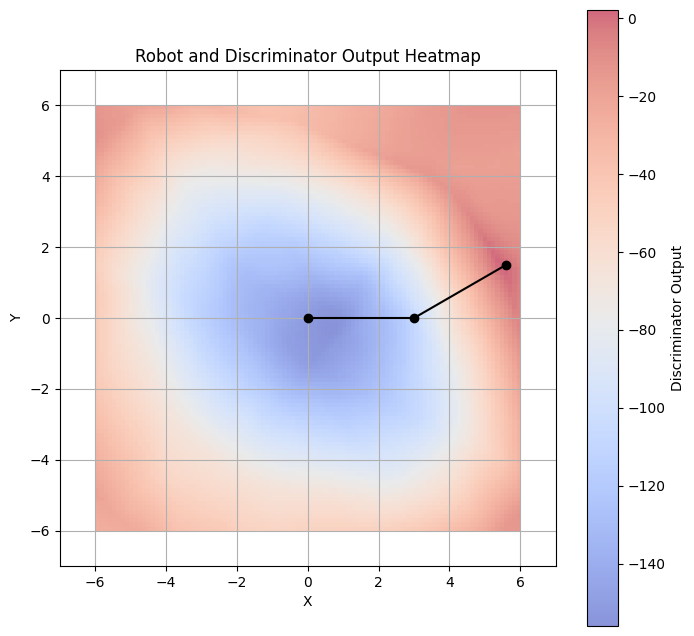

(np.float64(0.5235987755982985), np.float64(-0.523598775598298))


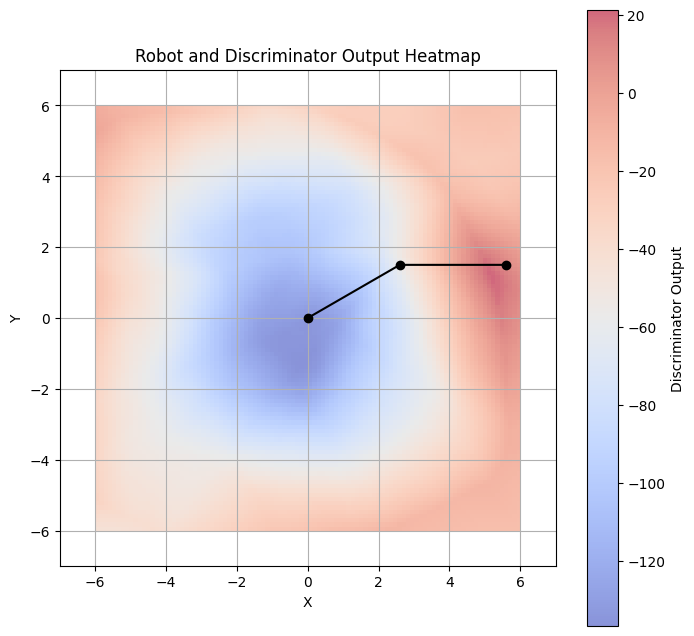

In [13]:
# Given angles
angles = (0, np.pi/6)  # Example angles

# Plot the robot and heatmap
plot_robot_and_heatmap(robot, discriminator, angles)

# Calculate the conjugate angle such that the target is the same
conjugate_angles = robot.get_conjugate_angles(angles)
print(conjugate_angles)

plot_robot_and_heatmap(robot, discriminator, conjugate_angles)

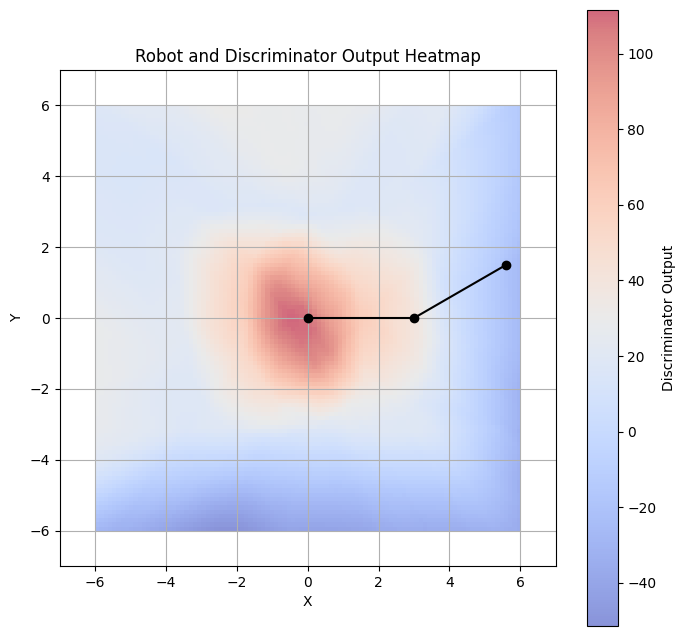

(0.5235987755982985, -0.523598775598298)


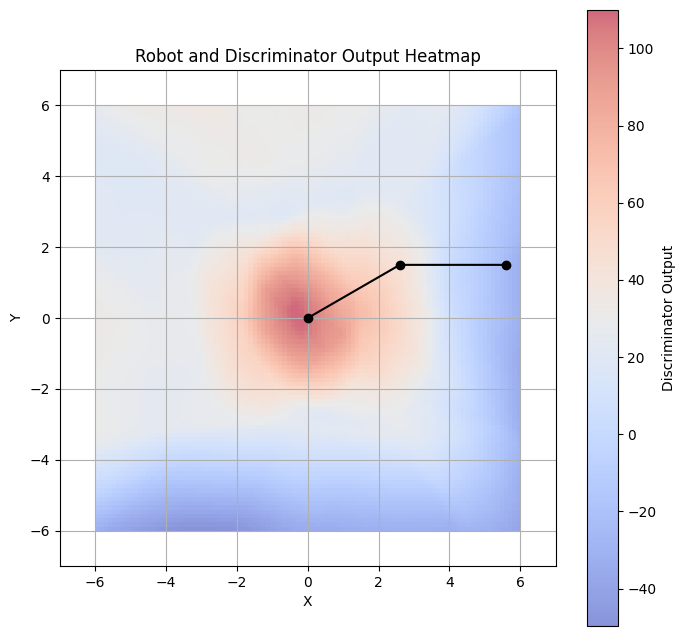

In [6]:
import torch
from methods.ebgan import Generator, EnergyModel
from robot import TwoLinkRobotIK

# Load the model
action_size = 2
condition_size = 2
hidden_size = 64
latent_size = 2
output_size = 1

discriminator_eb = EnergyModel(condition_size, action_size, hidden_size)
discriminator_eb.load_state_dict(torch.load('logs/ebgan_training/energy_model.pth', weights_only=True))

# Load the robot
# Robot parameters
L1 = 3.0  # Length of link 1
L2 = 3.0  # Length of link 2

# Create the robot
robot = TwoLinkRobotIK(L1, L2)

# Given angles
angles = (0, np.pi/6)  # Example angles

# Plot the robot and heatmap
plot_robot_and_heatmap(robot, discriminator_eb, angles)

# Calculate the conjugate angle such that the target is the same
conjugate_angles = robot.get_conjugate_angles(angles)
print(conjugate_angles)

plot_robot_and_heatmap(robot, discriminator_eb, conjugate_angles)

# Illustration of the idea

## Hyperbola Example

In [17]:
# utility 
import numpy as np
import matplotlib.pyplot as plt

# Define a decorator that randomly selects one of the multi-valued outputs
def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper


True


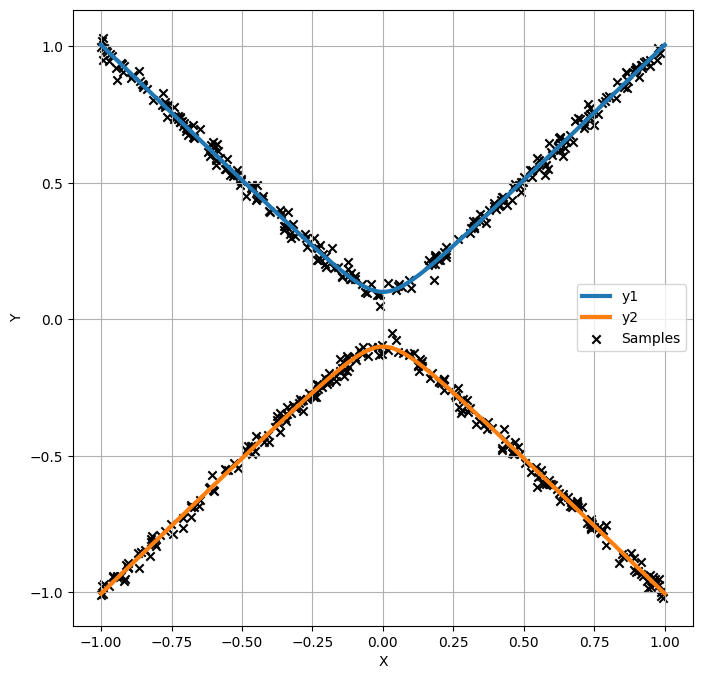

In [20]:
# Multi-valude function of x -> y1, y2, y3 ...
def y_circle(x, r = 1):
    y1 = np.sqrt(r - x**2)
    y2 = -np.sqrt(r - x**2)
    return y1, y2

def y_line(x, m = 1):
    return m * x, 0, -m * x

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

y_multi = y_hyperbola

# Apply the rand_mod function to y_circle
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

# # If we want not conflicting data
# num_samples = 500
# x = np.random.uniform(-1, 1, num_samples)
# y = np.array([y_multi(x_i)[0] for x_i in x])

print(x.shape == y.shape)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=3)

# plt.hist2d(x, y, bins=50, cmap='viridis', alpha=0.5)
plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()

# Save the image
plt.savefig('asset/proposal/hyperbola_data.png', dpi = 300)

plt.show()



In [4]:
# Train A MLP model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

def train(model, dataloader, criterion, optimizer, scheduler, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            positions = batch_x
            angles = batch_y
            
            outputs = model(positions)
            loss = criterion(outputs, angles)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

# Hyperparameters
input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 100
batch_size = 32
learning_rate = 0.001

# Prepare the dataset and dataloader
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Initialize model, criterion and optimizer
mlp = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# Train the model
train(mlp, dataloader, criterion, optimizer, scheduler, num_epochs)

Epoch [1/100], Loss: 0.3417, LR: 0.001000
Epoch [2/100], Loss: 0.3412, LR: 0.001000
Epoch [3/100], Loss: 0.3388, LR: 0.001000
Epoch [4/100], Loss: 0.3400, LR: 0.001000
Epoch [5/100], Loss: 0.3340, LR: 0.001000
Epoch [6/100], Loss: 0.3366, LR: 0.001000
Epoch [7/100], Loss: 0.3364, LR: 0.001000
Epoch [8/100], Loss: 0.3349, LR: 0.001000
Epoch [9/100], Loss: 0.3343, LR: 0.001000
Epoch [10/100], Loss: 0.3383, LR: 0.001000
Epoch [11/100], Loss: 0.3390, LR: 0.001000
Epoch [12/100], Loss: 0.3386, LR: 0.001000
Epoch [13/100], Loss: 0.3363, LR: 0.001000
Epoch [14/100], Loss: 0.3378, LR: 0.001000
Epoch [15/100], Loss: 0.3346, LR: 0.001000
Epoch [16/100], Loss: 0.3380, LR: 0.001000
Epoch [17/100], Loss: 0.3363, LR: 0.001000
Epoch [18/100], Loss: 0.3343, LR: 0.001000
Epoch [19/100], Loss: 0.3361, LR: 0.001000
Epoch [20/100], Loss: 0.3375, LR: 0.001000
Epoch [21/100], Loss: 0.3310, LR: 0.001000
Epoch [22/100], Loss: 0.3353, LR: 0.001000
Epoch [23/100], Loss: 0.3358, LR: 0.001000
Epoch [24/100], Loss

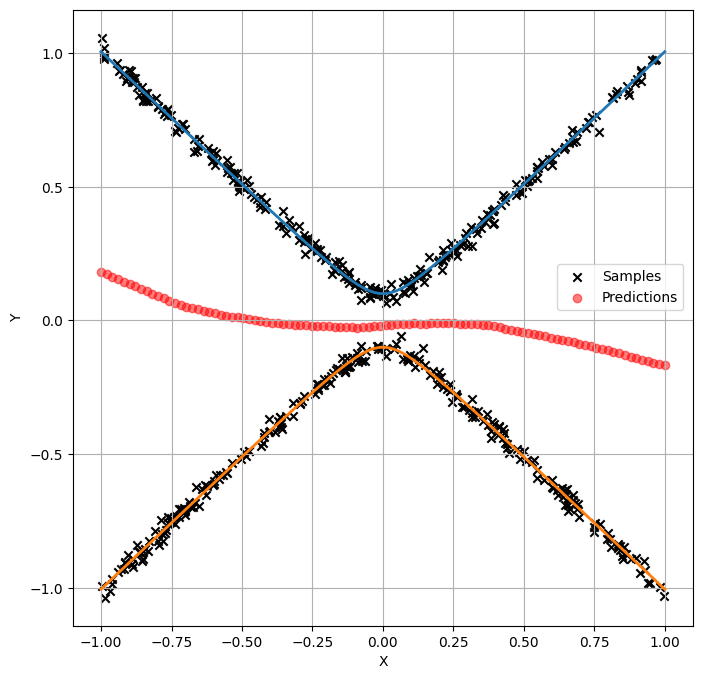

In [75]:
# Random sample the query points and get the predictions
num_query_points = 100
# query_points = np.random.uniform(-1, 1, num_query_points)
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
predictions = mlp(query_points_tensor).detach().numpy()


# Plot the function, samples, and predictions
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(0.77, 0.55))
plt.savefig('asset/proposal/hyperbola_mlp.png', dpi = 300)
plt.show()

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import argparse

# Generator architecture remains the same
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Generator, self).__init__()
        self.latent_size = input_size
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# Discriminator modified to output raw logits instead of sigmoid
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
            # Removed sigmoid to get raw logits
        )

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

def compute_discriminator_loss(discriminator, real_samples, fake_samples, condition):
    """Compute discriminator loss using log probabilities as per the formula"""
    # Get discriminator outputs
    d_real = discriminator(real_samples, condition)
    d_fake = discriminator(fake_samples, condition)
    
    # Compute log probabilities
    log_prob_real = torch.log(torch.sigmoid(d_real) + 1e-10)  # Add small epsilon to prevent log(0)
    log_prob_fake = torch.log(1 - torch.sigmoid(d_fake) + 1e-10)
    
    # Average over batch
    loss = -(torch.mean(log_prob_real) + torch.mean(log_prob_fake))
    
    return loss, torch.mean(torch.sigmoid(d_real)), torch.mean(torch.sigmoid(d_fake))

def compute_generator_loss(discriminator, fake_samples, condition):
    """Compute generator loss using log probabilities as per the formula"""
    d_fake = discriminator(fake_samples, condition)
    loss = -torch.mean(torch.log(torch.sigmoid(d_fake) + 1e-10))
    return loss

def train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs):
    # Training loop following the algorithm in the image
    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            position = batch_x
            angles = batch_y
            
            # Step 1: Update discriminator
            for _ in range(30):  # Can adjust number of discriminator updates per generator update
                # Draw noise samples
                z = torch.randn(position.size(0), generator.latent_size)
                
                # Generate fake samples
                fake_angles = generator(z, position)
                
                # Update discriminator
                d_loss, real_score, fake_score = compute_discriminator_loss(
                    discriminator, angles, fake_angles.detach(), position
                )
                
                optimizer_d.zero_grad()
                d_loss.backward()
                optimizer_d.step()

            # Step 2 & 3: Update generator
            z = torch.randn(position.size(0), generator.latent_size)
            fake_angles = generator(z, position)
            g_loss = compute_generator_loss(discriminator, fake_angles, position)
            
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")



    
# Hyperparameters
latent_size = 0
hidden_size = 64
output_size = 1
condition_size = 1
num_epochs = 200
batch_size = 100
learning_rate_d = 0.0002
learning_rate_g = 0.00005

# Prepare the dataset and dataloader
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(latent_size, hidden_size, output_size, condition_size)
discriminator = Discriminator(output_size, hidden_size, 1, condition_size)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

train(dataloader, generator, discriminator, optimizer_g, optimizer_d, num_epochs)

Epoch [1/200], Discriminator Loss: 0.3672, Generator Loss: 2.1156
Epoch [2/200], Discriminator Loss: 0.1073, Generator Loss: 4.1809
Epoch [3/200], Discriminator Loss: 0.2352, Generator Loss: 4.0591
Epoch [4/200], Discriminator Loss: 0.2404, Generator Loss: 2.7139
Epoch [5/200], Discriminator Loss: 0.1598, Generator Loss: 3.6592
Epoch [6/200], Discriminator Loss: 0.1575, Generator Loss: 3.6261
Epoch [7/200], Discriminator Loss: 0.0972, Generator Loss: 4.1136
Epoch [8/200], Discriminator Loss: 0.1425, Generator Loss: 4.0173
Epoch [9/200], Discriminator Loss: 0.0955, Generator Loss: 4.4785
Epoch [10/200], Discriminator Loss: 0.1144, Generator Loss: 4.0391
Epoch [11/200], Discriminator Loss: 0.1243, Generator Loss: 3.9955
Epoch [12/200], Discriminator Loss: 0.1115, Generator Loss: 4.2747
Epoch [13/200], Discriminator Loss: 0.1313, Generator Loss: 4.1031
Epoch [14/200], Discriminator Loss: 0.1858, Generator Loss: 3.7187
Epoch [15/200], Discriminator Loss: 0.2919, Generator Loss: 2.8732
Epoc

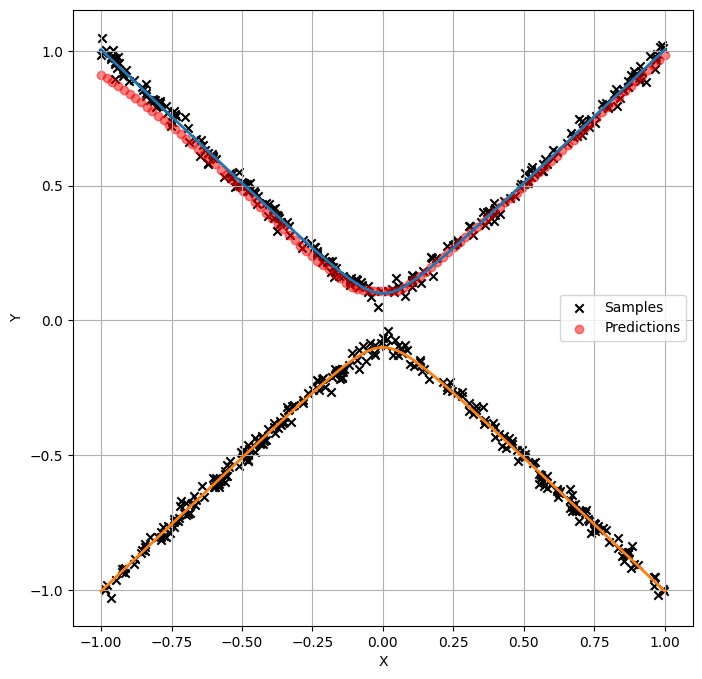

In [102]:
# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions = generator(z, query_points_tensor).detach().numpy()

# Plot the function, samples, and predictions
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]

# Plot the function, samples, and predictions
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.savefig('asset/proposal/hyperbola_gan.png', dpi = 300)
plt.show()


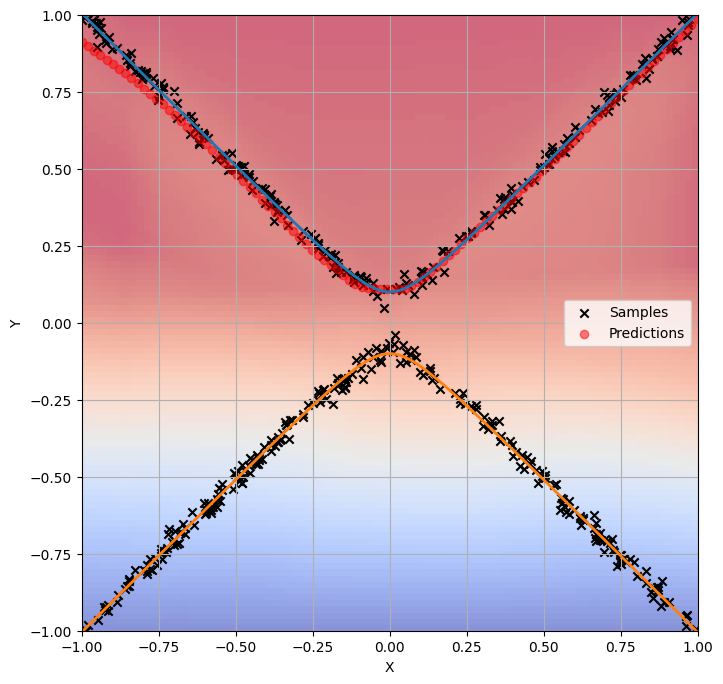

In [103]:
# Visualize the discriminator output heatmap
# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

# Compute discriminator output for each grid point
discriminator_outputs = []
for point in grid_points:
    x_plot = torch.tensor([point[0]], dtype=torch.float32).unsqueeze(0)
    y_plot = torch.tensor([point[1]], dtype=torch.float32).unsqueeze(0)
    output = discriminator(y_plot, x_plot).detach()
    # output = torch.sigmoid(discriminator(y_plot, x_plot)).detach()
    discriminator_outputs.append(output.item())

# Reshape the outputs to match the grid
discriminator_outputs = np.array(discriminator_outputs).reshape(100, 100)
# Normalize every column of the heatmap
discriminator_outputs = (discriminator_outputs - discriminator_outputs.min(axis=0)) / (discriminator_outputs.max(axis=0) - discriminator_outputs.min(axis=0))

# As energy, take minus of the discriminator output
discriminator_outputs = -discriminator_outputs

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(discriminator_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
# cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8)


# Plot the function
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

for i, y_val in enumerate(y_vals_transposed):
    ax.plot(x_vals, y_val,  linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
plt.savefig('asset/proposal/hyperbola_gan.png', dpi = 300)
plt.show()




Epoch [1/100], Generator Loss: 15.4823
Epoch [2/100], Generator Loss: 15.8793
Epoch [3/100], Generator Loss: 12.9957
Epoch [4/100], Generator Loss: 14.2326
Epoch [5/100], Generator Loss: 14.9266
Epoch [6/100], Generator Loss: 13.4863
Epoch [7/100], Generator Loss: 13.9801
Epoch [8/100], Generator Loss: 12.1906
Epoch [9/100], Generator Loss: 12.8771
Epoch [10/100], Generator Loss: 13.6473
Epoch [11/100], Generator Loss: 12.4831
Epoch [12/100], Generator Loss: 11.6116
Epoch [13/100], Generator Loss: 12.3286
Epoch [14/100], Generator Loss: 12.8052
Epoch [15/100], Generator Loss: 12.7550
Epoch [16/100], Generator Loss: 12.7605
Epoch [17/100], Generator Loss: 12.1979
Epoch [18/100], Generator Loss: 11.0137
Epoch [19/100], Generator Loss: 10.7035
Epoch [20/100], Generator Loss: 10.4528
Epoch [21/100], Generator Loss: 9.7426
Epoch [22/100], Generator Loss: 11.1604
Epoch [23/100], Generator Loss: 8.7920
Epoch [24/100], Generator Loss: 9.8136
Epoch [25/100], Generator Loss: 8.9584
Epoch [26/100

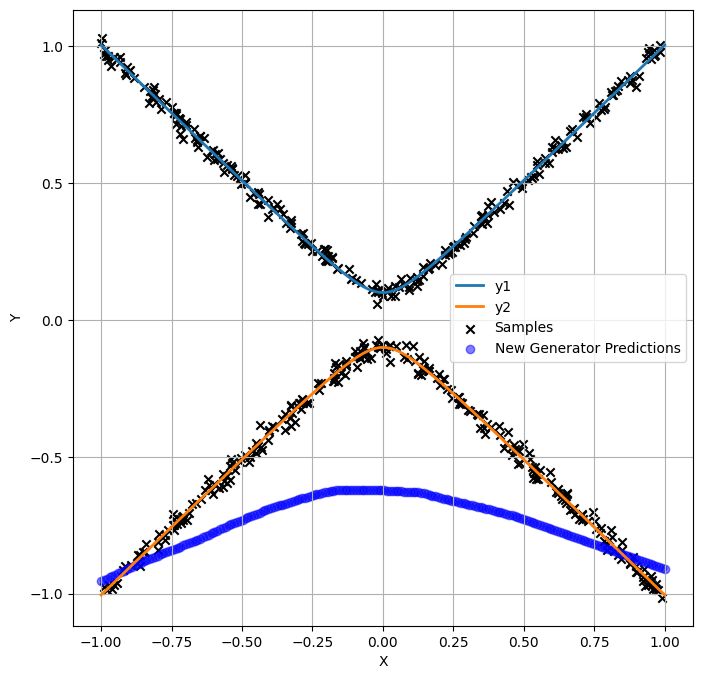

In [15]:
# Fix the discriminator and train a new generator
# Fix the discriminator parameters
for param in discriminator.parameters():
    param.requires_grad = False

# Initialize a new generator
new_generator = Generator(latent_size, hidden_size, output_size, condition_size)

# Optimizer for the new generator
optimizer_new_g = optim.Adam(new_generator.parameters(), lr=learning_rate_g)

# Training loop for the new generator
num_epochs_new_g = 100
for epoch in range(num_epochs_new_g):
    for batch_x, batch_y in dataloader:
        position = batch_x
        angles = batch_y
        
        # Draw noise samples
        z = torch.randn(position.size(0), new_generator.latent_size)
        
        # Generate fake samples
        fake_angles = new_generator(z, position)
        
        # Compute generator loss
        g_loss = compute_generator_loss(discriminator, fake_angles, position)
        
        # Update generator
        optimizer_new_g.zero_grad()
        g_loss.backward()
        optimizer_new_g.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs_new_g}], Generator Loss: {g_loss.item():.4f}")
    
    
# Random sample the query points and get the predictions using new_generator
num_query_points = 200
query_points = np.linspace(-1, 1, num_query_points)
query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1)
z = torch.randn(num_query_points, latent_size)
predictions_new = new_generator(z, query_points_tensor).detach().numpy()

# Plot the function, samples, and predictions from new_generator
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

plt.figure(figsize=(8, 8))
for i, y_val in enumerate(y_vals_transposed):
    plt.plot(x_vals, y_val, label=f'y{i+1}', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.scatter(query_points, predictions_new, marker='o', color='blue', label='New Generator Predictions', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend()
plt.show()

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Define Energy-based Model using MLP
class EnergyModel(nn.Module):
    def __init__(self, input_size, action_size, hidden_size):
        super(EnergyModel, self).__init__()
        self.energy_net = nn.Sequential(
            nn.Linear(input_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=-1)
        return self.energy_net(combined).squeeze(-1)

# InfoNCE-style loss function
def info_nce_loss(energy_model, x, y, counter_samples):
    positive_energy = -energy_model(x, y)
    neg_energies = torch.stack([-energy_model(x, neg) for neg in counter_samples], dim=1)
    denominator = torch.logsumexp(torch.cat([positive_energy.unsqueeze(-1), neg_energies], dim=-1), dim=-1)
    return torch.mean(denominator - positive_energy)

# Counter-sample generation
def generate_counter_samples(y_min, y_max, batch_size, neg_count, device):
    counter_samples = [torch.rand((batch_size, y_min.size(-1)), device=device) * (y_max - y_min) + y_min for _ in range(neg_count)]
    return counter_samples

# Training loop
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs, y_min, y_max, neg_count, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            positions = batch_x.to(device)
            angles = batch_y.to(device)
            
            counter_samples = generate_counter_samples(y_min, y_max, positions.size(0), neg_count, device)
            
            # Compute loss
            loss = criterion(model, positions, angles, counter_samples)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
# Hyperparameters
input_size = 1  # x, y positions
action_size = 1  # joint angles
hidden_size = 64
num_epochs = 100
batch_size = 32
neg_count = 256
learning_rate = 0.001

# Data bounds for counter-sample generation
y_min = torch.tensor([-1])  # Joint angle limits (radians)
y_max = torch.tensor([1])

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Load dataset
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer, scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
energy_model = EnergyModel(input_size, action_size, hidden_size).to(device)
optimizer = optim.Adam(energy_model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


# Train the model
train(energy_model, dataloader, info_nce_loss, optimizer, scheduler, num_epochs, y_min.to(device), y_max.to(device), neg_count, device)


Epoch [1/100], Loss: 5.5407, LR: 0.001000
Epoch [2/100], Loss: 5.5210, LR: 0.001000
Epoch [3/100], Loss: 5.5012, LR: 0.001000
Epoch [4/100], Loss: 5.4770, LR: 0.001000
Epoch [5/100], Loss: 5.4466, LR: 0.001000
Epoch [6/100], Loss: 5.4091, LR: 0.001000
Epoch [7/100], Loss: 5.3629, LR: 0.001000
Epoch [8/100], Loss: 5.3042, LR: 0.001000
Epoch [9/100], Loss: 5.2413, LR: 0.001000
Epoch [10/100], Loss: 5.1692, LR: 0.001000
Epoch [11/100], Loss: 5.0894, LR: 0.001000
Epoch [12/100], Loss: 5.0198, LR: 0.001000
Epoch [13/100], Loss: 4.9490, LR: 0.001000
Epoch [14/100], Loss: 4.8734, LR: 0.001000
Epoch [15/100], Loss: 4.8153, LR: 0.001000
Epoch [16/100], Loss: 4.7594, LR: 0.001000
Epoch [17/100], Loss: 4.6875, LR: 0.001000
Epoch [18/100], Loss: 4.6389, LR: 0.001000
Epoch [19/100], Loss: 4.5823, LR: 0.001000
Epoch [20/100], Loss: 4.5368, LR: 0.000500
Epoch [21/100], Loss: 4.4860, LR: 0.000500
Epoch [22/100], Loss: 4.4515, LR: 0.000500
Epoch [23/100], Loss: 4.4295, LR: 0.000500
Epoch [24/100], Loss

In [97]:
import torch

# Derivative-free optimizer for inference
def ebm_infer(energy_model, target_position, y_min, y_max, samples=16384, iterations=4, sigma_init=0.33, scale=0.5):
    """
    Find angles that minimize energy for a given target position.

    Args:
        energy_model: Trained energy-based model.
        target_position: Target position (Cartesian coordinates), shape: (1, input_dim).
        y_min: Minimum values for joint angles (tensor).
        y_max: Maximum values for joint angles (tensor).
        samples: Number of random samples for initial exploration.
        iterations: Number of optimization iterations.
        sigma_init: Initial noise level for exploration.
        scale: Scaling factor for noise reduction.

    Returns:
        Optimal joint angles minimizing the energy.
    """
    device = target_position.device
    target_position = target_position.repeat(samples, 1)  # Repeat for batch inference
    sigma = sigma_init

    # Initialize random joint angle samples
    angles = torch.rand((samples, y_min.size(-1)), device=device) * (y_max - y_min) + y_min

    for _ in range(iterations):
        # Compute energies for current samples
        # If energy_model is type EnergyModel, you can use energy_model(target_position, angles)
        # elif energy_model is typr Discriminator, you can use -energy_model(angles, target_position)
        if isinstance(energy_model, EnergyModel):
            energies = energy_model(target_position, angles)
        elif isinstance(energy_model, Discriminator):
            energies = -energy_model(angles, target_position)
        else:
            raise ValueError("Invalid energy model type.")

        # Softmax over negative energies for sampling probabilities
        probabilities = torch.softmax(-energies, dim=0)

        # Resample based on probabilities
        indices = torch.multinomial(probabilities, num_samples=samples, replacement=True)
        angles = angles[indices]

        # Add noise for exploration
        angles += torch.randn_like(angles) * sigma
        angles = torch.clamp(angles, y_min, y_max)  # Clamp to valid joint angle bounds

        # Reduce noise scale
        sigma *= scale

    # Return the angles corresponding to the minimum energy
    best_idx = torch.argmin(energies)
    return angles[best_idx].unsqueeze(0)  # Shape: (1, action_dim)


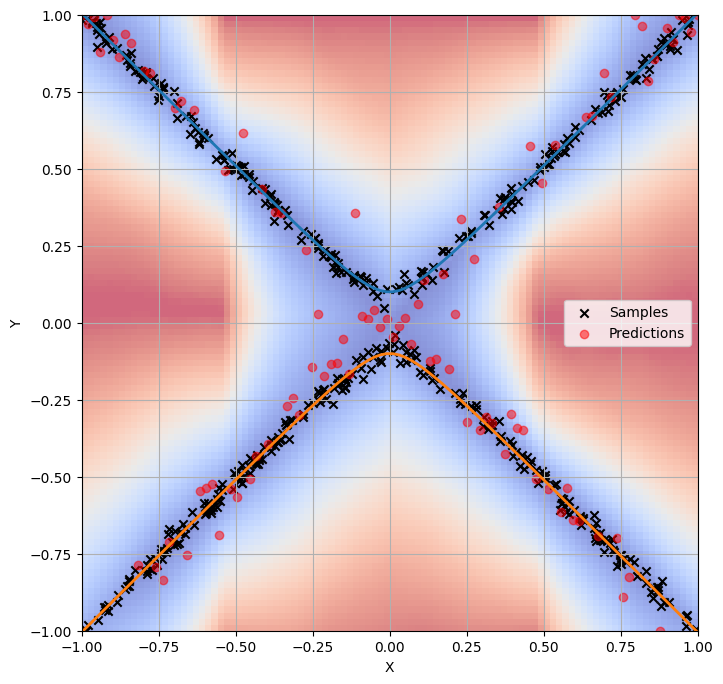

In [98]:

# Random sample the query points and get the predictions
num_query_points = 100
query_points = np.linspace(-1, 1, num_query_points)

predictions = []
for point in query_points:
    query_points_tensor = torch.tensor([[point]], dtype=torch.float32).to(device)
    prediction = ebm_infer(energy_model, query_points_tensor, y_min.to(device), y_max.to(device))
    predictions.append(prediction.item())


# Visualize the energy model output heatmap
# Generate grid points within the range of x values
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

# Compute energy model output for each grid point
energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
energy_outputs = energy_outputs.reshape(100, 100)

# Normalize every column of the heatmap
energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

# Plot the heatmap and the function, samples, and predictions in the same figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the heatmap
heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.6)
# plt.colorbar(heatmap, ax=ax, label='Energy Model Output')

# Plot the function
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

for i, y_val in enumerate(y_vals_transposed):
    ax.plot(x_vals, y_val, linewidth=2)

# Plot the samples and predictions
ax.scatter(x, y, marker='x', color='black', label='Samples')
ax.scatter(query_points, predictions, marker='o', color='red', label='Predictions', alpha=0.5)

# Set limits to cut the plot within -1, 1
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
plt.savefig('asset/proposal/hyperbola_ebm.png', dpi = 300)
plt.show()




---

## Two Link Robot Example

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from robot import TwoLinkRobotIK
from methods.mlp import MLP
from methods.cgan import Generator, Discriminator
from methods.cvae import CVAE 
from methods.reinforce import PolicyNetwork
#from methods.ibc import EnergyModel
from methods.cwgan import Critic
from methods.ebgan import EnergyModel
from utils import ebm_infer

# Robot parameters
L1 = 3.0  # Length of link 1
L2 = 3.0  # Length of link 2

# Create the robot
robot = TwoLinkRobotIK(L1, L2)

# Hyperparameters
input_size = 2
hidden_size = 64
output_size = 2
latent_size = 2
action_size = 2

# cgan and cvae 
condition_size = 2

# cvae
input_dim = 2
latent_dim = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_type):
    if model_type == 'mlp':
        model = MLP(input_size, hidden_size, output_size).to(device)
        model.load_state_dict(torch.load('logs/mlp_model_gradient_data_rs/mlp_model_gradient_data_rs.pth', map_location=device))
        model.eval()
        return model
    elif model_type == 'cvae':
        cvae = CVAE(input_dim, condition_size, hidden_size, latent_dim).to(device)
        cvae.load_state_dict(torch.load('logs/cvae_model_gradient_data_rs/cvae_model_gradient_data_rs.pth', map_location=device))
        cvae.eval()
        return cvae
    elif model_type == 'reinforce':
        reinforce_policy_net = PolicyNetwork(input_size, hidden_size, output_size).to(device)
        reinforce_policy_net.load_state_dict(torch.load('logs/REINFORCE/reinforce_model.pth', map_location=device))
        reinforce_policy_net.eval()
        return reinforce_policy_net
    elif model_type == 'ibc':
        energy_model = EnergyModel(input_size=input_size, action_size=output_size, hidden_size=hidden_size).to(device)
        energy_model.load_state_dict(torch.load('logs/ibc_model_gradient_data_rs/ibc_model_gradient_data_rs.pth', map_location=device))
        energy_model.eval()
        return energy_model
    elif model_type == 'cgan':
        generator = Generator(latent_size, hidden_size, output_size, condition_size).to(device)
        generator.load_state_dict(torch.load('logs/cgan_model_gradient_data_rs/generator_gradient_data_rs.pth', map_location=device))
        generator.eval()
        cgan_discriminator = Discriminator(output_size, hidden_size, 1, condition_size).to(device)
        cgan_discriminator.load_state_dict(torch.load('logs/cgan_model_gradient_data_rs/discriminator_gradient_data_rs.pth', map_location=device))
        cgan_discriminator.eval()
        return generator, cgan_discriminator
    elif model_type == 'ebgan':
        ebgan_model = Generator(latent_size, hidden_size, output_size, condition_size).to(device)
        ebgan_model.load_state_dict(torch.load('logs/ebgan_training/generator.pth', map_location=device))
        ebgan_model.eval()
        ebgan_em = EnergyModel(condition_size, action_size, hidden_size).to(device)
        ebgan_em.load_state_dict(torch.load('logs/ebgan_training/energy_model.pth', map_location=device))
        ebgan_em.eval()
        return ebgan_model, ebgan_em
    elif model_type == 'cwgan':
        cwgan_model = Generator(latent_size, hidden_size, output_size, condition_size).to(device)
        cwgan_model.load_state_dict(torch.load('logs/cwgan_model_gradient_data_rs/generator_gradient_data_rs.pth', map_location=device))
        cwgan_model.eval()
        cwgan_critic = Critic(output_size, hidden_size, 1, condition_size).to(device)
        cwgan_critic.load_state_dict(torch.load('logs/cwgan_model_gradient_data_rs/discriminator_gradient_data_rs.pth', map_location=device))
        cwgan_critic.eval()
        return cwgan_model, cwgan_critic
    else:
        raise ValueError("Invalid model type")

def ik_methods(method, target_position):
    if method == 'gradient_descent':
        target_position = [float(target_position[0]), float(target_position[1])]
        return robot.solve_ik_gradient_descent(target_position)
    elif method == 'mlp':
        input_tensor = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)
        output_tensor = mlp_model(input_tensor)
        return output_tensor[0].detach().cpu().tolist()
    elif method == 'cvae':
        condition = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)
        latent_sample = torch.randn(1, latent_dim, device=device)
        return cvae_model.decoder(latent_sample, condition).detach().cpu().tolist()[0]
    elif method == 'reinforce':
        input_tensor = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)
        output_tensor, _ = reinforce_model(input_tensor)
        return output_tensor[0].detach().cpu().tolist()
    elif method == 'ibc':
        target_tensor = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)
        y_min = torch.tensor([-3.14, -3.14], device=device)
        y_max = torch.tensor([3.14, 3.14], device=device)
        inferred_angles = ebm_infer(energy_model, target_tensor, y_min, y_max)
        return inferred_angles.cpu().tolist()[0]
    elif method == 'cgan':
        latent_vector = torch.randn(1, latent_size, device=device)
        condition = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)
        return cgan_model(latent_vector, condition).detach().cpu().tolist()[0]
    elif method == 'ebgan':
        latent_vector = torch.randn(1, latent_size, device=device)
        condition = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)
        return ebgan_model(latent_vector, condition).detach().cpu().tolist()[0]
    elif method == 'cwgan':
        latent_vector = torch.randn(1, latent_size, device=device)
        condition = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)
        return cwgan_model(latent_vector, condition).detach().cpu().tolist()[0]
    else:
        raise ValueError("Invalid method type")

def plot_and_save(method_type, target_position):
    global mlp_model, cgan_model, cvae_model, reinforce_model, energy_model, ebgan_model, cwgan_model, cwgan_critic, ebgan_em, cgan_discriminator

    if method_type == 'mlp':
        mlp_model = load_model('mlp')
    elif method_type == 'cvae':
        cvae_model = load_model('cvae')
    elif method_type == 'reinforce':
        reinforce_model = load_model('reinforce')
    elif method_type == 'ibc':
        energy_model = load_model('ibc')
    elif method_type == 'cgan':
        cgan_model, cgan_discriminator = load_model('cgan')
    elif method_type == 'ebgan':
        ebgan_model, ebgan_em = load_model('ebgan')
    elif method_type == 'cwgan':
        cwgan_model, cwgan_critic = load_model('cwgan')
        

    # Initialize plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-L1 - L2 , L1 + L2 )
    ax.set_ylim(-L1 - L2 , L1 + L2 )
    ax.set_aspect('equal', adjustable='box')
    ax.grid()
    # plt.title(f"2-Link Robotic Arm - {method_type.upper()}")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    # Add a circle to represent the workspace range
    workspace_circle = plt.Circle((0, 0), L1 + L2, color='gray', fill=False, linestyle='--',linewidth=1.5)
    ax.add_artist(workspace_circle)

    # Create a grid of target positions
    x_range = np.linspace(-L1 - L2, L1 + L2, 100)
    y_range = np.linspace(-L1 - L2, L1 + L2, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X)

    if method_type != 'gradient_descent':  # For all methods except gradient descent
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                target_position_grid = (X[i, j], Y[i, j])
                theta1, theta2 = ik_methods(method_type, target_position_grid)
                Z[i, j] = robot.evaluate(theta1, theta2, target_position_grid[0], target_position_grid[1])

        heatmap = ax.imshow(Z, extent=(-L1 - L2, L1 + L2, -L1 - L2, L1 + L2), origin='lower', cmap='coolwarm', alpha=0.6)

    # Plot the target position
    target_x, target_y = target_position
    ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')

    # Plot the robot
    theta1, theta2 = ik_methods(method_type, target_position)
    joint1 = (L1 * np.cos(theta1), L1 * np.sin(theta1))
    end_effector = (joint1[0] + L2 * np.cos(theta1 + theta2), joint1[1] + L2 * np.sin(theta1 + theta2))
    ax.plot([0, joint1[0], end_effector[0]], [0, joint1[1], end_effector[1]], '-o', label=f'Robot', color='red', alpha = 0.5, linewidth=2.5)
    # Add legend
    ax.legend()
    # Save the plot
    plt.savefig(f'asset/proposal/robot_{method_type}_{target_position[0]}_{target_position[1]}.png')
    plt.show()



/var/folders/30/dxk9z97n3sg6ghl0d6b3f_dh0000gn/T/ipykernel_20184/798522231.py:159: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')


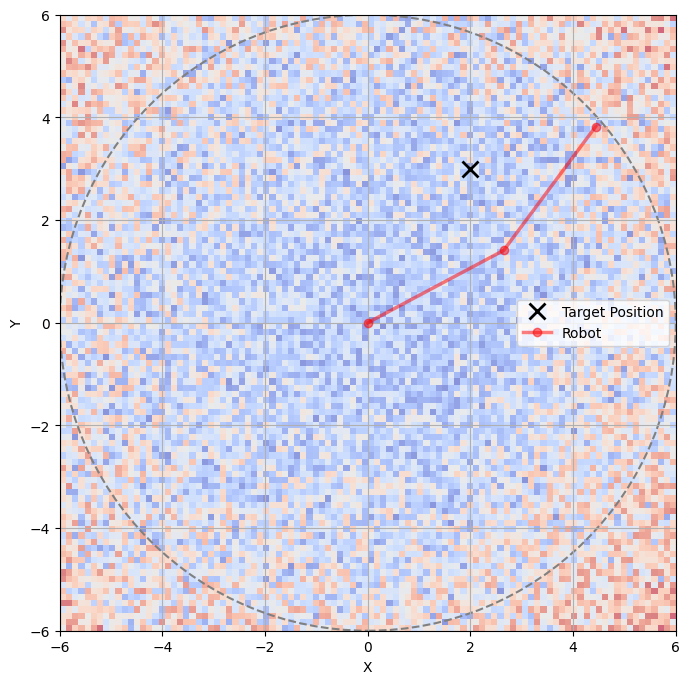

In [42]:
method_type = 'cwgan'
target_position = [2.0, 3.0]
plot_and_save(method_type, target_position)

/var/folders/30/dxk9z97n3sg6ghl0d6b3f_dh0000gn/T/ipykernel_20184/798522231.py:159: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')


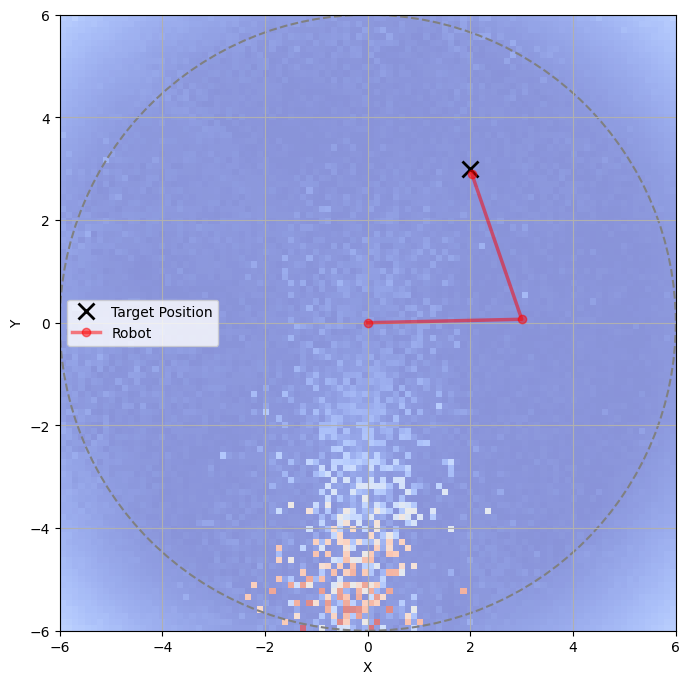

In [44]:
method_type = 'cgan'  # Change this to the desired method
target_position = [2.0, 3.0]  # Change this to the desired target position
plot_and_save(method_type, target_position)

/var/folders/30/dxk9z97n3sg6ghl0d6b3f_dh0000gn/T/ipykernel_20184/1757802160.py:159: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')


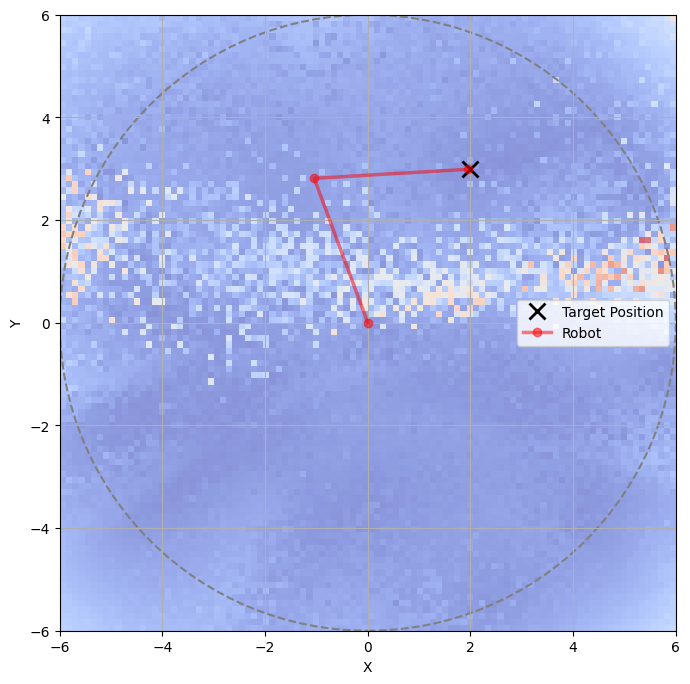

In [84]:
method_type = 'ebgan'  # Change this to the desired method
target_position = [2.0, 3.0]  # Change this to the desired target position
plot_and_save(method_type, target_position)

/var/folders/30/dxk9z97n3sg6ghl0d6b3f_dh0000gn/T/ipykernel_20184/798522231.py:159: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')


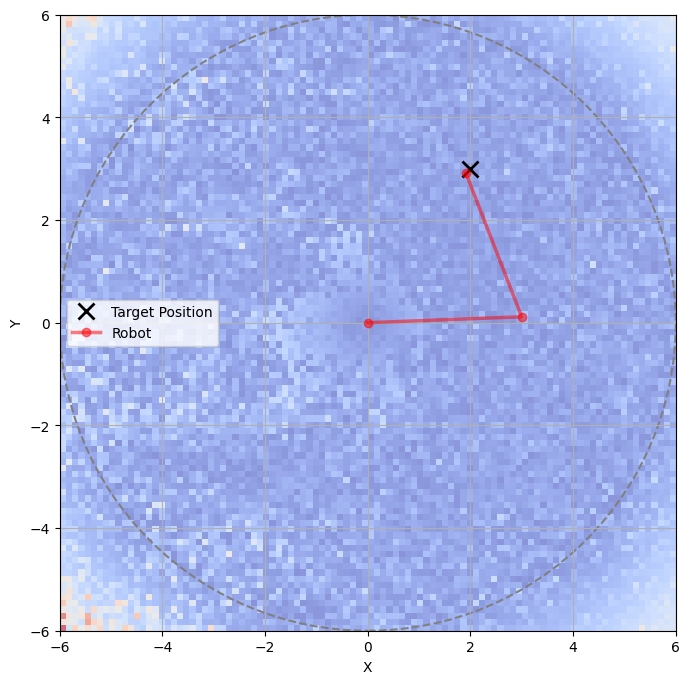

In [39]:
method_type = 'ibc'
target_position = [2.0, 3.0]  # Change this to the desired target position
plot_and_save(method_type, target_position)

/tmp/ipykernel_43032/1290835280.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')


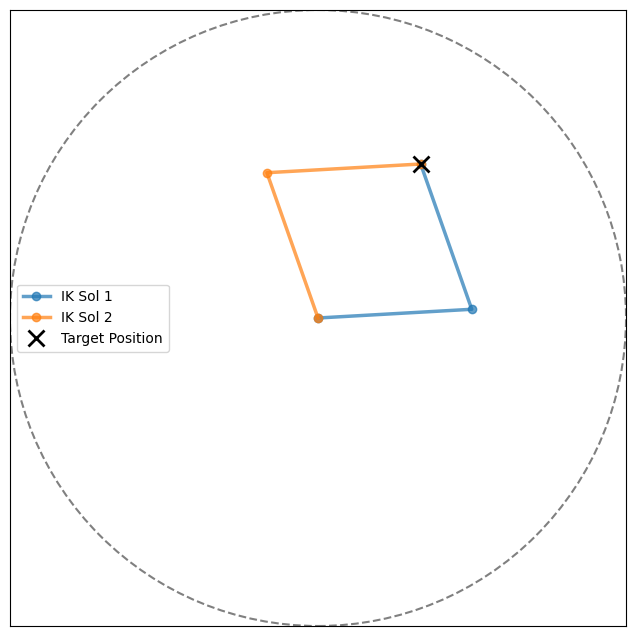

In [10]:
target_position = [2.0, 3.0]
target_x, target_y = target_position
# Solve IK analytically
solutions = robot.solve_ik_analytical(target_x, target_y)

# Initialize plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-L1 - L2 , L1 + L2 )
ax.set_ylim(-L1 - L2 , L1 + L2 )
ax.set_aspect('equal', adjustable='box')

# Hide ticks and axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Add a circle to represent the workspace range
workspace_circle = plt.Circle((0, 0), L1 + L2, color='gray', fill=False, linestyle='--', linewidth=1.5)
ax.add_artist(workspace_circle)

# Plot robot configurations
for i, (theta1, theta2) in enumerate(solutions):
    # Compute joint positions using numpy
    joint1 = (L1 * np.cos(theta1), L1 * np.sin(theta1))
    end_effector = (joint1[0] + L2 * np.cos(theta1 + theta2), joint1[1] + L2 * np.sin(theta1 + theta2))

    # Plot the robot arm
    ax.plot([0, joint1[0], end_effector[0]], [0, joint1[1], end_effector[1]], '-o', label=f'IK Sol {i+1}', alpha=0.7, linewidth=2.5)
    

# Plot the target position
ax.plot(target_x, target_y, 'rx', label='Target Position', markersize=12, markeredgewidth=2, color='black')

# Add legend
ax.legend()

plt.savefig(f'asset/proposal/robot_ik_analytical_{target_position[0]}_{target_position[1]}.png')

# Show plot
plt.show()

## Energy Landscape

In [32]:
def plot_landscape(method_type, target_position):
    """
    Plot the discriminator or energy landscape for a given target position.

    Parameters:
        method_type (str): The method type ('cgan', 'ebgan', 'cwgan', 'ibc').
        target_position (list): The target position as [x, y].
    """
    global cgan_model, cgan_discriminator, ebgan_model, ebgan_em, cwgan_model, cwgan_critic, energy_model

    # Load the required model(s)
    if method_type == 'cgan':
        cgan_model, cgan_discriminator = load_model('cgan')
        model_to_evaluate = cgan_discriminator
    elif method_type == 'ebgan':
        ebgan_model, ebgan_em = load_model('ebgan')
        model_to_evaluate = ebgan_em
    elif method_type == 'cwgan':
        cwgan_model, cwgan_critic = load_model('cwgan')
        model_to_evaluate = cwgan_critic
    elif method_type == 'ibc':
        energy_model = load_model('ibc')
        model_to_evaluate = energy_model
    else:
        raise ValueError("Invalid method type")

    # Initialize plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-L1 - L2, L1 + L2)
    ax.set_ylim(-L1 - L2, L1 + L2)
    ax.set_aspect('equal', adjustable='box')
    ax.grid()
    plt.xlabel("X")
    plt.ylabel("Y")
    
    # Add a circle to represent the workspace range
    workspace_circle = plt.Circle((0, 0), L1 + L2, color='gray', fill=False, linestyle='--', linewidth=1.5)
    ax.add_artist(workspace_circle)

    # Create a grid of target positions
    x_range = np.linspace(-L1 - L2, L1 + L2, 100)
    y_range = np.linspace(-L1 - L2, L1 + L2, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X)

    # Evaluate the landscape for the given method
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            grid_position = [X[i, j], Y[i, j]]  # Candidate output (angles)
            angles = torch.tensor(grid_position, dtype=torch.float32, device=device).unsqueeze(0)
            condition = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)

            if method_type in ['cgan', 'cwgan']:
                Z[i, j] = model_to_evaluate(angles, condition).item()
            elif method_type in ['ebgan', 'ibc']:
                Z[i, j] = model_to_evaluate(condition, angles).item()

    # Print subset of Z for debugging
    print("Sample Z values:", Z[::10, ::10])

    # Plot the heatmap
    heatmap = ax.imshow(Z, extent=(-L1 - L2, L1 + L2, -L1 - L2, L1 + L2), origin='lower', cmap='coolwarm')
    plt.colorbar(heatmap, ax=ax, label='Discriminator/Energy Output')

    # Plot the target position
    target_x, target_y = target_position
    ax.plot(target_x, target_y, 'kx', label='Target Position', markersize=12, markeredgewidth=2)

    # Predict angles using the generator
    if method_type in ['cgan', 'ebgan', 'cwgan']:
        latent_vector = torch.randn(1, latent_size, device=device)
        condition = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)
        if method_type == 'cgan':
            predicted_angles = cgan_model(latent_vector, condition).detach().cpu().numpy()[0]
        elif method_type == 'ebgan':
            predicted_angles = ebgan_model(latent_vector, condition).detach().cpu().numpy()[0]
        elif method_type == 'cwgan':
            predicted_angles = cwgan_model(latent_vector, condition).detach().cpu().numpy()[0]

        # Compute the end effector position from predicted angles
        joint1 = (L1 * np.cos(predicted_angles[0]), L1 * np.sin(predicted_angles[0]))
        end_effector = (
            joint1[0] + L2 * np.cos(predicted_angles[0] + predicted_angles[1]),
            joint1[1] + L2 * np.sin(predicted_angles[0] + predicted_angles[1])
        )

        # Plot the predicted position
        ax.plot([0, joint1[0], end_effector[0]], [0, joint1[1], end_effector[1]], '-o', label='Prediction', color='red', linewidth=2.5)

    # Add legend and show
    ax.legend()
    plt.show()

Sample Z values: [[ 17.33172417  14.49911594  19.16264343  28.94062042  43.79211426
   44.34031677  41.89683151  27.61745262  17.88002586  14.38759899]
 [ 19.86341858   5.50070286   3.38040638  10.48953533  29.11702538
   34.69036865  27.58027458  13.98562145  11.98108196  12.25380135]
 [ 49.17147827  16.55254555  -5.31995869  -5.67090607   9.2221384
   21.93346405  12.62190151   8.70553303  23.73190498  -1.12614441]
 [ 68.25255585  37.22299576  11.19624138 -17.30737686 -12.00653839
   -2.26116204   7.32769394  26.31097603  17.59158707   9.31526089]
 [ 91.17390442  64.49860382  37.29110336   8.41966724 -17.44456291
  -39.36239243  -5.0441885   20.44309807   2.16536999   0.8701086 ]
 [104.99546814  78.26709747  48.65142822  24.06755066 -18.4317627
  -79.66796875 -78.12227631 -54.76078796 -11.50418282   0.31114483]
 [ 99.71656036  71.73719788  49.77835464  11.32272625 -21.25294495
  -29.03559875 -70.42247009 -42.21967697  -3.0994339    8.5524168 ]
 [ 90.57682037  56.06070709  23.38630104

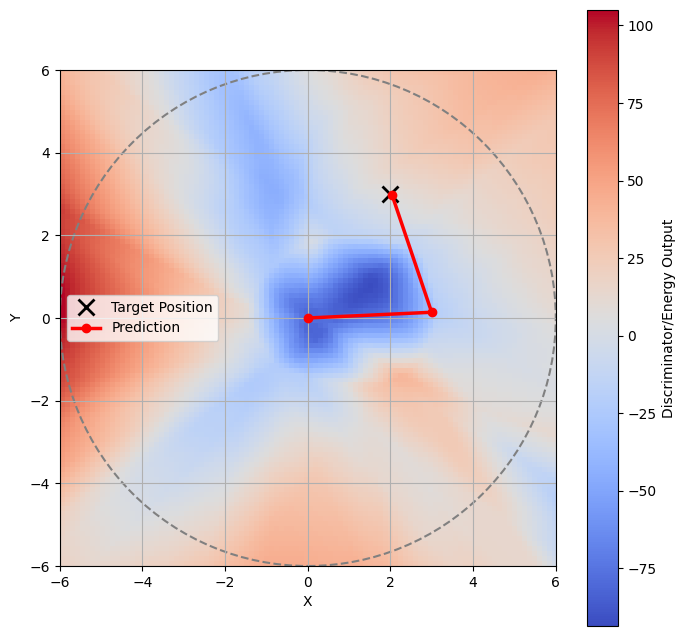

In [33]:
target_position = [2.0, 3.0]  # Example target position
method_type = 'cgan'  # Choose between 'cgan', 'ebgan', 'cwgan', 'ibc'
plot_landscape(method_type, target_position)

Sample Z values: [[-14.76273155 -23.18854332 -34.46129227 -40.200634   -36.99250031
  -38.87528229 -38.78539276 -35.09678268 -30.09526634 -16.78123856]
 [ 11.13646889   7.13829327  -0.33022332  -8.79501343  -7.64968634
   -6.23058653  -8.23304844  -5.39316034   2.74213362   5.56369305]
 [ 15.60038471  18.56279945  26.109972    46.12843704  50.59189987
   42.29384995  26.89567184  28.596241    25.43148613  12.59565639]
 [ 16.92687035  12.76923084  26.6662178   57.75424576  87.52796173
   75.18788147  46.28240967  21.88931656  33.25832367  17.69676018]
 [ 18.02858162  13.92262554  31.49146652  65.16891479  90.09046173
   99.02598572  35.50318527  29.49274445  38.0128212   19.57423019]
 [ 17.58241463  13.84347248  32.77332687  68.21744537  91.764534
   80.03350067  39.71316147  45.53210449  33.85473251  15.6459713 ]
 [ 10.85661221  12.51661491  26.61756134  60.54747772  60.38230515
   28.14405251  45.46843719  43.8163147   28.56658745   9.86975956]
 [  8.979002    13.10579586  18.63570213

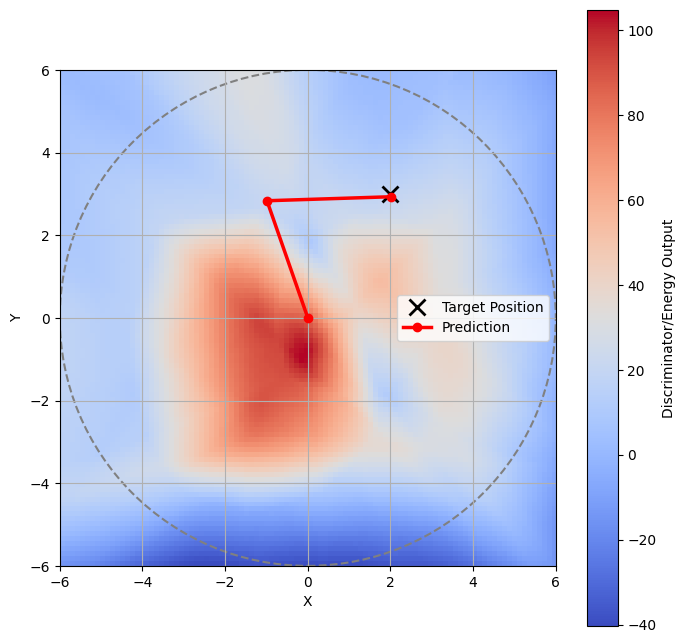

In [34]:
target_position = [2.0, 3.0]  # Example target position
method_type = 'ebgan'  # Choose between 'cgan', 'ebgan', 'cwgan', 'ibc'
plot_landscape(method_type, target_position)

In [22]:
def plot_discriminator_or_energy_landscape(method_type, target_position):
    global cgan_model, cgan_discriminator, ebgan_em, cwgan_critic, energy_model

    # Load the required model(s)
    if method_type == 'cgan':
        cgan_model, cgan_discriminator = load_model('cgan')
        model_to_evaluate = cgan_discriminator
    elif method_type == 'ebgan':
        ebgan_model, ebgan_em = load_model('ebgan')
        model_to_evaluate = ebgan_em
    elif method_type == 'cwgan':
        cwgan_model, cwgan_critic = load_model('cwgan')
        model_to_evaluate = cwgan_critic
    elif method_type == 'ibc':
        energy_model = load_model('ibc')
        model_to_evaluate = energy_model
    else:
        raise ValueError(f"Unsupported method type for this function: {method_type}")

    # Define range for joint angles
    theta1_range = np.linspace(-3.14, 3.14, 100)  # Joint angle 1
    theta2_range = np.linspace(-3.14, 3.14, 100)  # Joint angle 2
    Theta1, Theta2 = np.meshgrid(theta1_range, theta2_range)
    Z = np.zeros_like(Theta1)

    # Evaluate discriminator/energy model for each joint angle pair
    for i in range(Theta1.shape[0]):
        for j in range(Theta1.shape[1]):
            theta1 = Theta1[i, j]
            theta2 = Theta2[i, j]
            
            # Input to the model
            joint_angles = torch.tensor([theta1, theta2], dtype=torch.float32, device=device).unsqueeze(0)
            condition = torch.tensor(target_position, dtype=torch.float32, device=device).unsqueeze(0)

            # Evaluate based on method
            if method_type in ['cgan', 'cwgan']:
                output = model_to_evaluate(joint_angles, condition)  # Discriminator/Critic output
            elif method_type == 'ebgan':
                output = -model_to_evaluate(condition, joint_angles)  # Negative energy for EBGAN
            elif method_type == 'ibc':
                output = model_to_evaluate(condition, joint_angles)  # Energy model output
            
            Z[i, j] = output.item()

    # Plot the landscape
    plt.figure(figsize=(8, 8))
    plt.contourf(Theta1, Theta2, Z, levels=100, cmap='coolwarm', alpha=0.8)
    plt.colorbar(label="Discriminator/Energy Output")
    plt.title(f"{method_type.upper()} Landscape for Target {target_position}")
    plt.xlabel("Theta1 (radians)")
    plt.ylabel("Theta2 (radians)")
    plt.savefig(f'asset/proposal/{method_type}_landscape_{target_position[0]}_{target_position[1]}.png')
    plt.show()

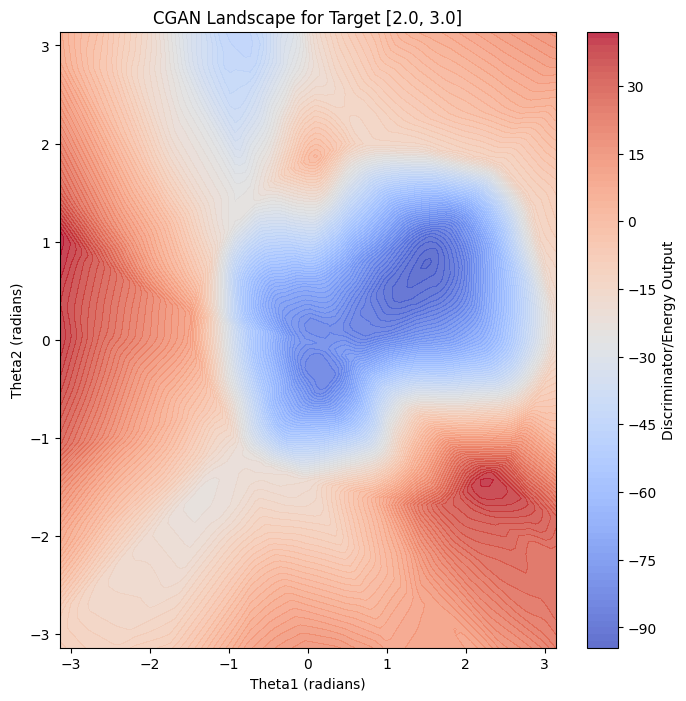

In [25]:
target_position = [2.0, 3.0]  # Example target position
method_type = 'cgan'  # Choose between 'cgan', 'ebgan', 'cwgan', 'ibc'
plot_discriminator_or_energy_landscape(method_type, target_position)

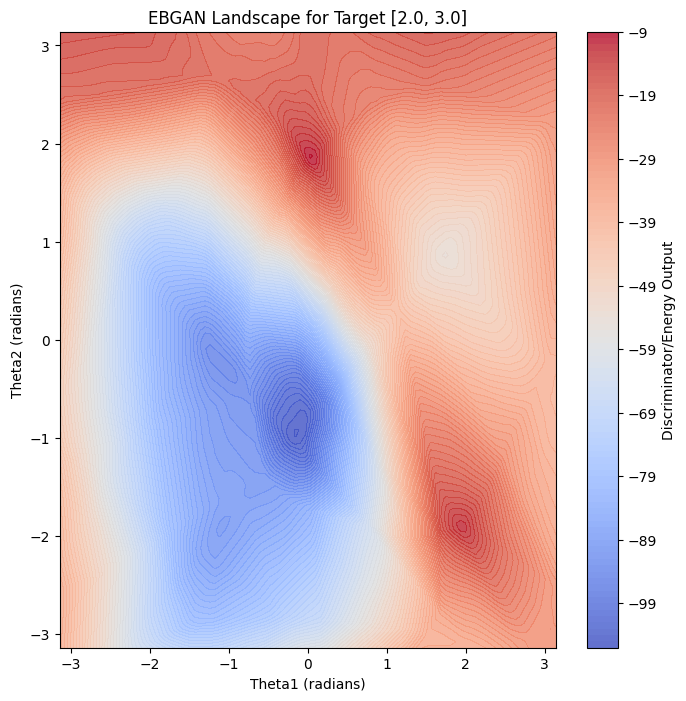

In [24]:
target_position = [2.0, 3.0]  # Example target position
method_type = 'ebgan'  # Choose between 'cgan', 'ebgan', 'cwgan', 'ibc'
plot_discriminator_or_energy_landscape(method_type, target_position)

# Energy vs. Probability Landscapes

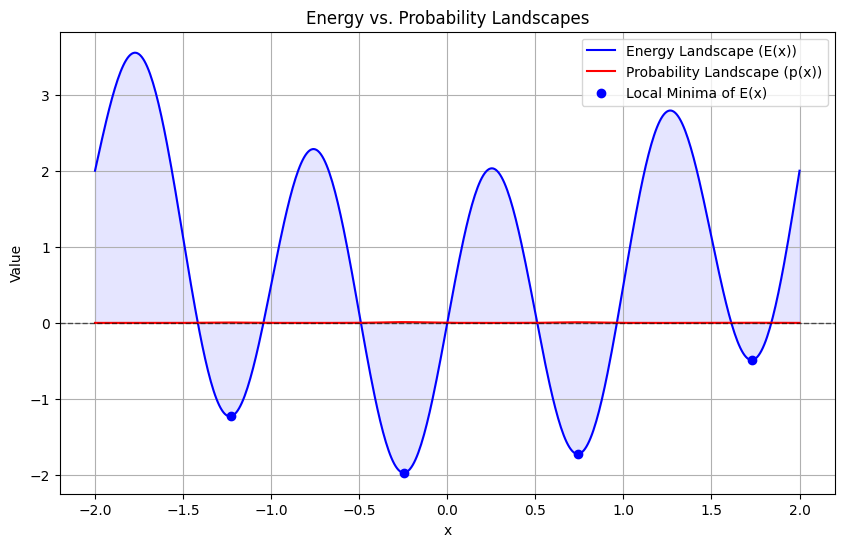

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Define a multimodal energy function
def energy(x):
    return np.sin(2 * np.pi * x) * 2 + 0.5 * (x ** 2)

# Compute probabilities from energy
def probability(x):
    E = energy(x)
    return np.exp(-E) / np.sum(np.exp(-E))  # Normalize for visualization

# Generate domain
x = np.linspace(-2, 2, 500)

# Calculate energy and probability
E = energy(x)
P = probability(x)

# Plot energy landscape
plt.figure(figsize=(10, 6))
plt.plot(x, E, label='Energy Landscape (E(x))', color='blue')
plt.fill_between(x, E, alpha=0.1, color='blue')

# Plot probability landscape
plt.plot(x, P, label='Probability Landscape (p(x))', color='red')
plt.fill_between(x, P, alpha=0.1, color='red')

# Annotate minima
minima_x = x[np.r_[False, E[1:] < E[:-1]] & np.r_[E[:-1] < E[1:], False]]
minima_y = energy(minima_x)
plt.scatter(minima_x, minima_y, color='blue', label='Local Minima of E(x)', zorder=5)

# Customize plot
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.6)
plt.title('Energy vs. Probability Landscapes')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

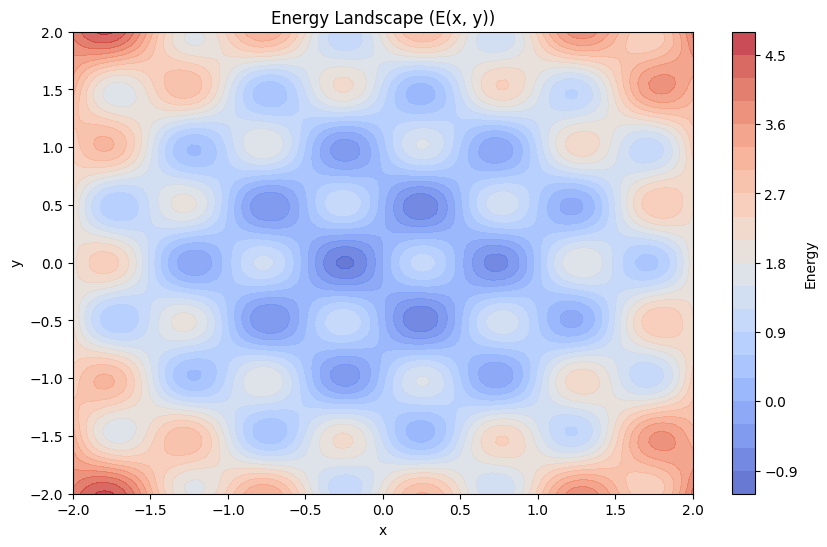

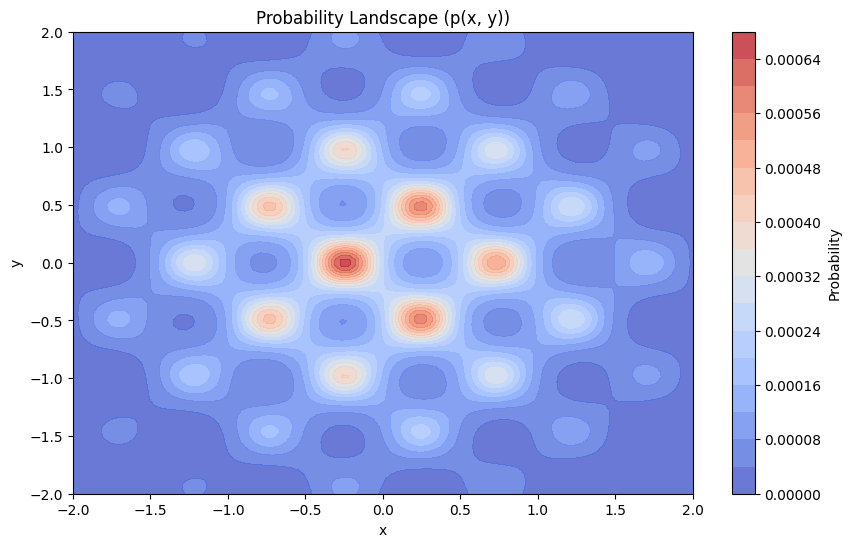

In [47]:
# 2D Multimodal Energy Function
def energy_2d(x, y):
    return np.sin(2 * np.pi * x) * np.cos(2 * np.pi * y) + 0.5 * (x ** 2 + y ** 2)

# Generate 2D domain
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
E = energy_2d(X, Y)
P = np.exp(-E) / np.sum(np.exp(-E))  # Normalize

# Plot Energy Landscape
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, E, levels=20, cmap='coolwarm', alpha=0.8)
plt.colorbar(label='Energy')
plt.title('Energy Landscape (E(x, y))')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Plot Probability Landscape
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, P, levels=20, cmap='coolwarm', alpha=0.8)
plt.colorbar(label='Probability')
plt.title('Probability Landscape (p(x, y))')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

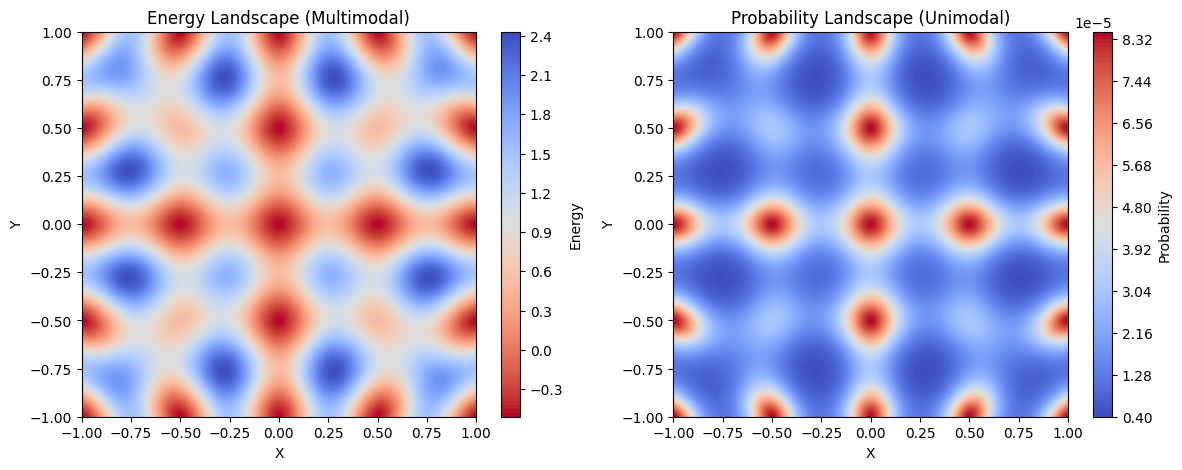

In [66]:
# Cleaned-up version of the script for visualizing energy and probability landscapes

# Define the energy function
def energy_function(x, y):
    return (
        np.sin(2 * np.pi * x) ** 2 +
        np.sin(2 * np.pi * y) ** 2 -
        0.5 * np.cos(4 * np.pi * x * y)
    )

# Compute probability as normalized energy
def probability_function(energy):
    exp_neg_energy = np.exp(-energy)
    return exp_neg_energy / np.sum(exp_neg_energy)


def complex_energy_function(x, y):
    return (
        np.exp(-((x + 3)**2 + (y + 3)**2) / 2) + 
        np.exp(-((x - 3)**2 + (y - 3)**2) / 2) +
        np.exp(-((x - 2)**2 + (y + 2)**2) / 0.5)
    )

def complex_energy_landscape(x, y):
    return -np.log(complex_energy_function(x, y) + 1e-6)

def sigmoid_like_energy(e):
    return 1 / (1 + np.exp(e - 5)) 

# Generate grid for visualization
grid_size = 200
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)

# Calculate energy landscape
Z_energy = energy_function(X, Y)

# Calculate probability landscape
Z_probability = probability_function(Z_energy)

# Save data to ensure reproducibility
data = {"X": X, "Y": Y, "Z_energy": Z_energy, "Z_probability": Z_probability}
np.savez("energy_vs_probability_landscape.npz", **data)

# Visualize the energy landscape
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z_energy, levels=100, cmap="coolwarm_r")
plt.colorbar(label="Energy")
plt.title("Energy Landscape (Multimodal)")
plt.xlabel("X")
plt.ylabel("Y")

# Visualize the probability landscape
plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z_probability, levels=100, cmap="coolwarm")
plt.colorbar(label="Probability")
plt.title("Probability Landscape (Unimodal)")
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("probability_landscape.png")
plt.show()

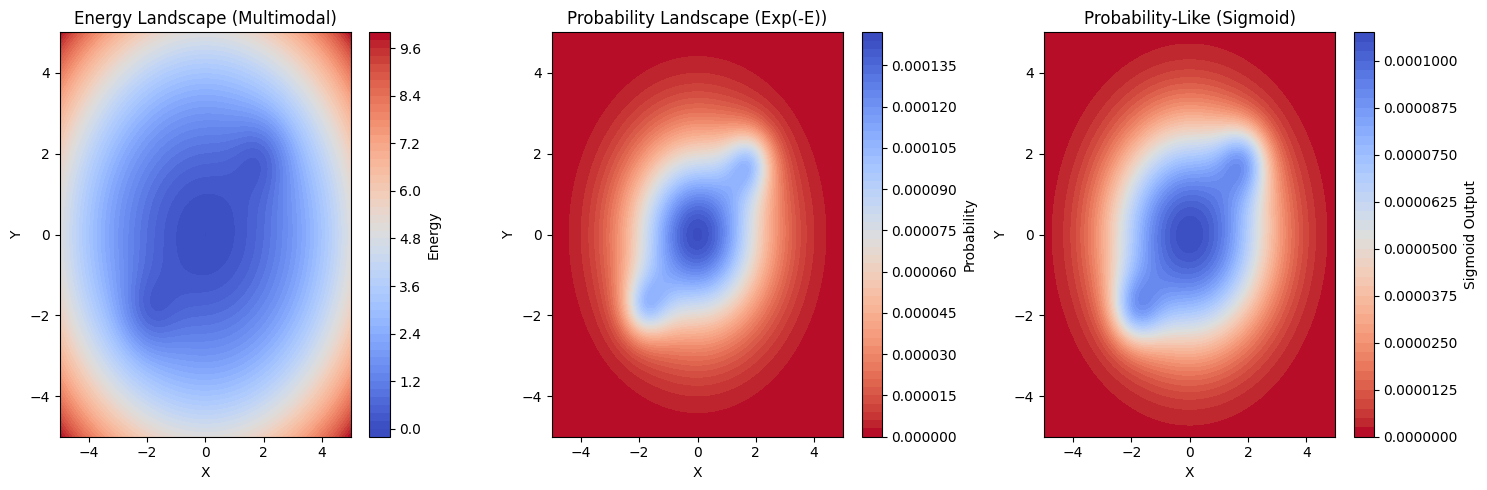

In [79]:
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)

# Define a multimodal energy function
# Peaks centered at (-2, -2), (2, 2), and a valley in between
E = (
    -np.exp(-((X + 2)**2 + (Y + 2)**2))  # Deep valley at (-2, -2)
    -np.exp(-((X - 2)**2 + (Y - 2)**2))  # Deep valley at (2, 2)
    + 0.2 * ((X)**2 + (Y)**2)  # Shallow rise in the middle
)

# Correct Probability Transformation: P(x) ~ exp(-E(x))
P_correct = np.exp(-E)
P_correct /= P_correct.sum()  # Normalize to simulate probabilities

# Incorrect Transformation: Using a sigmoid to show "swallowing" effect
P_sigmoid = 1 / (1 + np.exp(E))  # Sigmoid squashing the energy values


P_sigmoid = P_sigmoid / np.sum(P_sigmoid)

# Plot the Energy Landscape
plt.figure(figsize=(15, 5))

# Energy Landscape
plt.subplot(1, 3, 1)
plt.contourf(X, Y, E, levels=50, cmap='coolwarm', norm=Normalize(vmin=np.min(E), vmax=np.max(E)))
plt.colorbar(label='Energy')
plt.title('Energy Landscape (Multimodal)')
plt.xlabel('X')
plt.ylabel('Y')

# Correct Probability Distribution
plt.subplot(1, 3, 2)
plt.contourf(X, Y, P_correct, levels=50, cmap='coolwarm_r', norm=Normalize(vmin=np.min(P_correct), vmax=np.max(P_correct)))
plt.colorbar(label='Probability')
plt.title('Probability Landscape (Exp(-E))')
plt.xlabel('X')
plt.ylabel('Y')

# Incorrect Sigmoid Transformation
plt.subplot(1, 3, 3)
plt.contourf(X, Y, P_sigmoid, levels=50, cmap='coolwarm_r', norm=Normalize(vmin=np.min(P_sigmoid), vmax=np.max(P_sigmoid)))
plt.colorbar(label='Sigmoid Output')
plt.title('Probability-Like (Sigmoid)')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.savefig('energy_vs_probability_fixed.png', dpi=300)
plt.show()

In [64]:
def complex_energy_function(x, y):
    return (
        np.exp(-((x + 3)**2 + (y + 3)**2) / 2) + 
        np.exp(-((x - 3)**2 + (y - 3)**2) / 2) +
        np.exp(-((x - 2)**2 + (y + 2)**2) / 0.5)
    )

def complex_energy_landscape(x, y):
    return -np.log(complex_energy_function(x, y) + 1e-6)

def sigmoid_like_energy(e):
    return 1 / (1 + np.exp(e - 5)) 

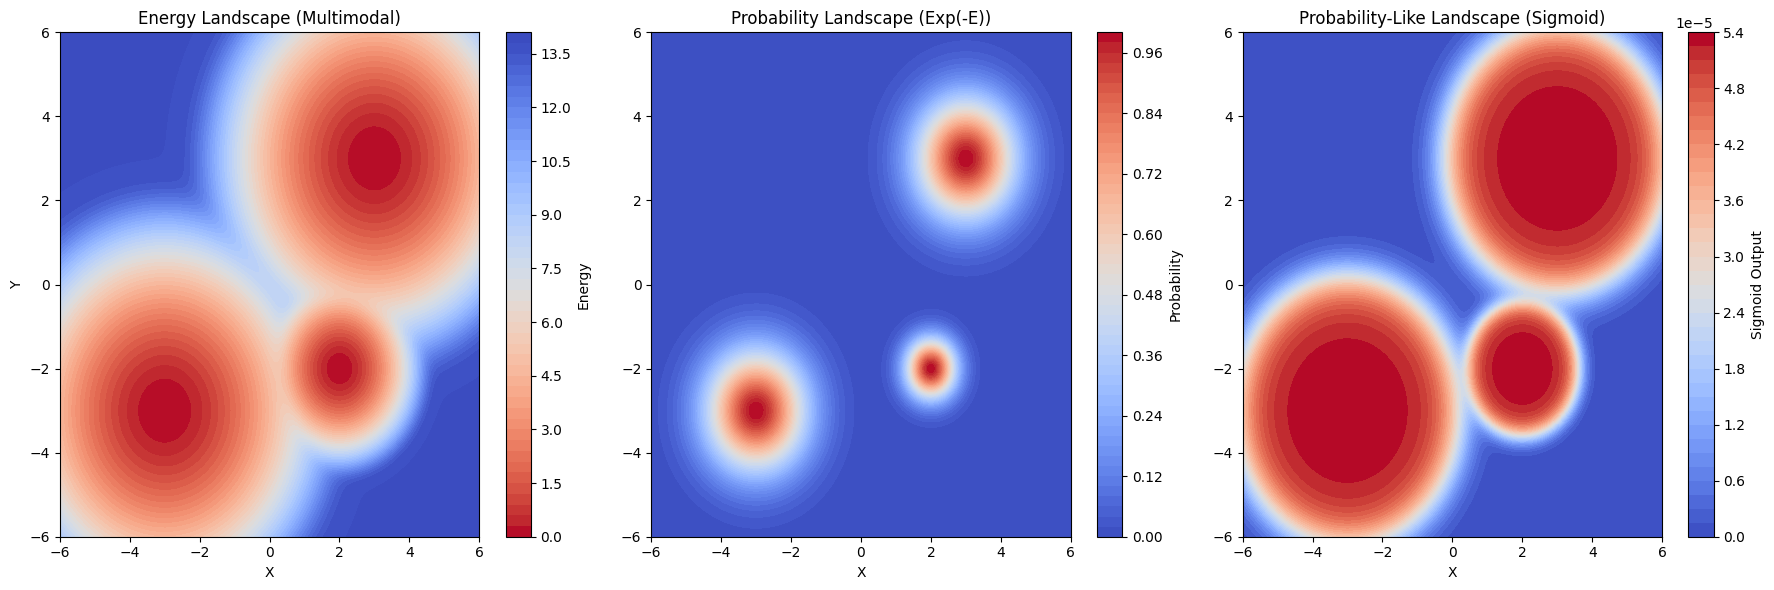

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Define the adjusted energy function with multiple modes
def complex_energy_function(x, y):
    return (
        np.exp(-((x + 3) ** 2 + (y + 3) ** 2) / 2) + 
        np.exp(-((x - 3) ** 2 + (y - 3) ** 2) / 2) +
        np.exp(-((x - 2) ** 2 + (y + 2) ** 2) / 0.5)
    )

# Define the energy landscape
def complex_energy_landscape(x, y):
    return -np.log(complex_energy_function(x, y) + 1e-6)

# Define a sigmoid-like transformation for energy to probability
def sigmoid_like_energy(e):
    return 1 / (1 + np.exp(e - 5))


def normalized_sigmoid_output(sigmoid_values):
    return sigmoid_values / np.sum(sigmoid_values)

# Generate grid points for the plot
x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 200)
X, Y = np.meshgrid(x, y)

# Calculate the energy and probability landscapes
energy_landscape = complex_energy_landscape(X, Y)
probability_exp = np.exp(-energy_landscape)  # exp(-E) for comparison
probability_sigmoid = sigmoid_like_energy(energy_landscape)
probability_sigmoid = normalized_sigmoid_output(probability_sigmoid)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Energy Landscape
ax = axes[0]
contour = ax.contourf(X, Y, energy_landscape, levels=50, cmap='coolwarm_r', norm=Normalize(vmin=0, vmax=np.max(energy_landscape)))
plt.colorbar(contour, ax=ax, label="Energy")
ax.set_title("Energy Landscape (Multimodal)")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Probability Landscape (Exp(-E))
ax = axes[1]
contour = ax.contourf(X, Y, probability_exp, levels=50, cmap='coolwarm', norm=Normalize(vmin=0, vmax=np.max(probability_exp)))
plt.colorbar(contour, ax=ax, label="Probability")
ax.set_title("Probability Landscape (Exp(-E))")
ax.set_xlabel("X")

# Probability-Like (Sigmoid)
ax = axes[2]
contour = ax.contourf(X, Y, probability_sigmoid, levels=50, cmap='coolwarm', norm=Normalize(vmin=0, vmax=np.max(probability_sigmoid)))
plt.colorbar(contour, ax=ax, label="Sigmoid Output")
ax.set_title("Probability-Like Landscape (Sigmoid)")
ax.set_xlabel("X")

plt.tight_layout()
plt.show()


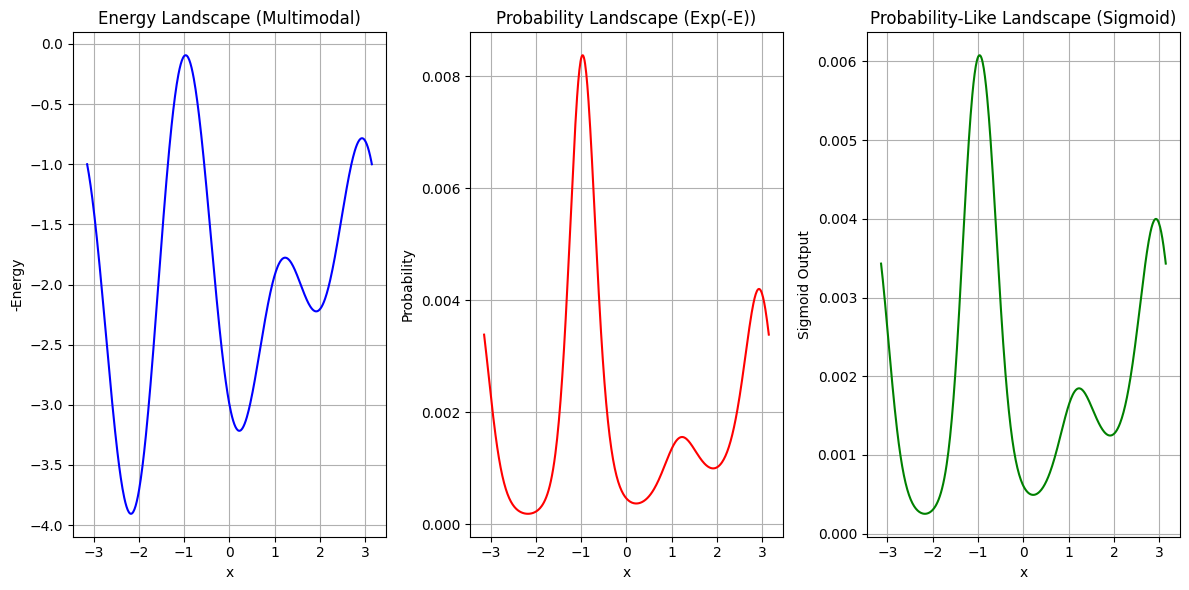

In [80]:

# Define the energy landscape (multimodal)
def energy_function(x):
    return np.sin(2 * x) + np.cos(3 * x) + 2  # Offset to keep values positive

# Compute the probability landscape using exp(-E)
def probability_landscape(energy):
    probabilities = np.exp(-energy)
    return probabilities / np.sum(probabilities)  # Normalize to sum to 1

# Compute a sigmoid-like probability landscape
def sigmoid_landscape(energy):
    return 1 / (1 + np.exp(energy))

# Generate the x values (1D range)
x = np.linspace(-np.pi, np.pi, 500)

# Compute the energy landscape
energy = energy_function(x)

# Compute the probability landscape
probabilities = probability_landscape(energy)

# Compute the sigmoid-like landscape
sigmoid_probs = sigmoid_landscape(energy)
sigmoid_probs = normalized_sigmoid_output(sigmoid_probs)

# Plotting the results
plt.figure(figsize=(12, 6))

# Energy landscape
plt.subplot(1, 3, 1)
plt.plot(x, -energy, color='blue')
plt.title('Energy Landscape (Multimodal)')
plt.xlabel('x')
plt.ylabel('-Energy')
plt.grid()

# Probability landscape
plt.subplot(1, 3, 2)
plt.plot(x, probabilities, color='red')
plt.title('Probability Landscape (Exp(-E))')
plt.xlabel('x')
plt.ylabel('Probability')
plt.grid()

# Sigmoid-like landscape
plt.subplot(1, 3, 3)
plt.plot(x, sigmoid_probs, color='green')
plt.title('Probability-Like Landscape (Sigmoid)')
plt.xlabel('x')
plt.ylabel('Sigmoid Output')
plt.grid()

plt.tight_layout()
plt.show()

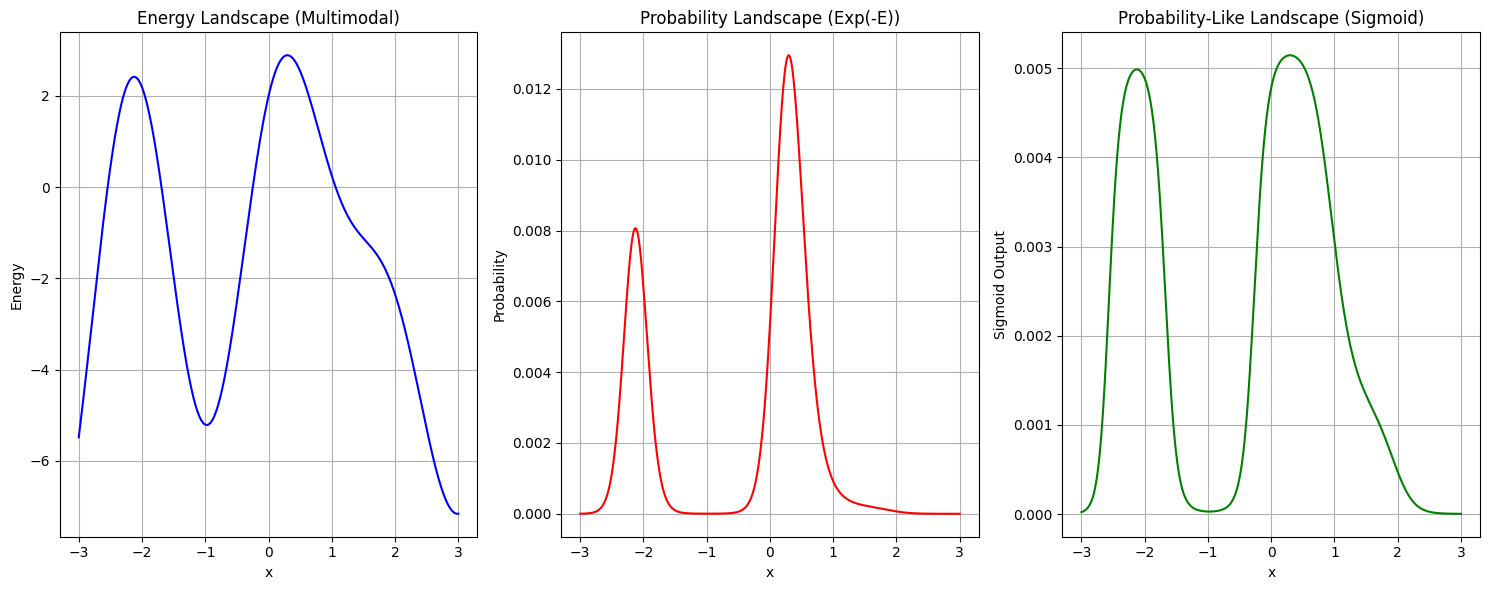

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Define the energy function with more contrast
def energy_function(x):
    return -3 * np.sin(2 * x) - 2 * np.cos(3 * x) + 0.5 * x**2

# Define probability landscape using exp(-E)
def probability_from_energy(E):
    return np.exp(-E) / np.sum(np.exp(-E))  # Normalized probabilities

# Define sigmoid-like mapping
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def normalized_sigmoid_output(sigmoid_values):
    return sigmoid_values / np.sum(sigmoid_values)

# Generate x values
x = np.linspace(-3, 3, 500)

# Compute landscapes
energy = energy_function(x)
probability = probability_from_energy(energy)
sigmoid_output = sigmoid(-energy)  # Flipped energy for sigmoid visualization
normalized_sigmoid = normalized_sigmoid_output(sigmoid_output)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Energy Landscape
axs[0].plot(x, -energy, color='blue')
axs[0].set_title("Energy Landscape (Multimodal)")
axs[0].set_xlabel("x")
axs[0].set_ylabel("Energy")
axs[0].grid(True)

# Probability Landscape
axs[1].plot(x, probability, color='red')
axs[1].set_title("Probability Landscape (Exp(-E))")
axs[1].set_xlabel("x")
axs[1].set_ylabel("Probability")
axs[1].grid(True)

# Sigmoid-Like Landscape
axs[2].plot(x, normalized_sigmoid, color='green')
axs[2].set_title("Probability-Like Landscape (Sigmoid)")
axs[2].set_xlabel("x")
axs[2].set_ylabel("Sigmoid Output")
axs[2].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()